## Import Libraries

In [9]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import urllib
import datetime
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [43]:
pattern_fpath = '../Data/inputs/safegraph_open_census_data/data/cbg_patterns.csv'
if not os.path.exists(pattern_fpath):
    os.makedirs('../data/inputs/safegraph_open_census_data/data/', exist_ok=True)
    pattern_bucket_url = "https://storage.googleapis.com/safegraph-mobility-2018-data/cbg_patterns.csv"
    resultFilePath, responseHeaders = urllib.request.urlretrieve(pattern_bucket_url, pattern_fpath)

geo_fpath = '../Data/inputs/cbg_geographic_data.csv'
df_geo = pd.read_csv(geo_fpath)

df_pattern = pd.read_csv(pattern_fpath)
df_pattern = df_pattern.drop(columns=['date_range_start','date_range_end',
                                      'related_same_day_brand','related_same_month_brand','top_brands'])

df_geo_pat = df_geo.join(df_pattern.set_index('census_block_group'), on='census_block_group')

## Filter Data

Text(0, 0.5, 'Count')

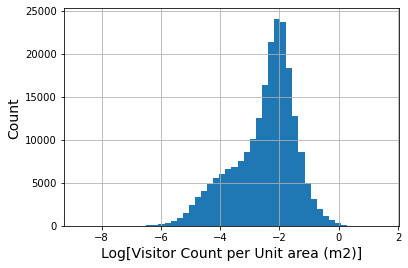

In [44]:
df_geo_pat = df_geo_pat[df_geo_pat['amount_land']!=0]
df_geo_pat['uniq_visitors_per_month_per_m2'] = df_geo_pat['raw_visitor_count']/df_geo_pat['amount_land']

col = 'uniq_visitors_per_month_per_m2'
df_geo_pat['log_' + col] = np.log10(df_geo_pat[col])
df_geo_pat['log_' + col].hist(bins=50)
plt.xlabel('Log[Visitor Count per Unit area (m2)]', fontsize =14)
plt.ylabel('Count', fontsize =14)

## Select CBG with Higher Visitor/m2 

Number of CBGs =  29001
% CBGs (Filtered CBGs/Total CBGs) =  13.0


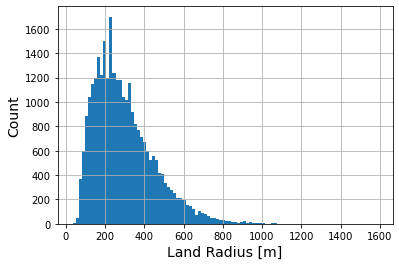

In [45]:
threshold = -1.5
df_above_mean_log = (df_geo_pat[df_geo_pat['log_uniq_visitors_per_month_per_m2'] > threshold])

df_above_mean_log['land_radius'] = (np.sqrt(df_above_mean_log['amount_land']/np.pi))
df_above_mean_log['land_radius'].hist(bins=100)
plt.xlabel('Land Radius [m]', fontsize =14)
plt.ylabel('Count', fontsize =14)
print('Number of CBGs = ', len(df_above_mean_log))
print('% CBGs (Filtered CBGs/Total CBGs) = ',np.round(len(df_above_mean_log)*100/len(df_geo_pat)))

## Spatial Map of Selected CBGs

In [6]:
from folium import plugins
import folium

us_cen = [39.5, -98.35]
base_map = folium.Map(location=us_cen,zoom_start=4)
count = df_above_mean_log[['latitude', 'longitude']].to_numpy()
base_map.add_child(plugins.HeatMap(count,radius=15))
base_map

### Review Scraper

In [21]:

import sys
import time
import importlib

sys.path.append('..')
st_time  = time.time() 

from src.utils import cbg_rest_etl
importlib.reload(cbg_rest_etl)
cbg_writer = cbg_rest_etl.CBG()

from src.utils import rest_attr_etl
importlib.reload(rest_attr_etl)
rest_attr_scraper = rest_attr_etl.rest_attr()

from src.utils import review_etl
importlib.reload(review_etl)
review_scraper = review_etl.ReviewScraper()



rest_attr_scraper = rest_attr_etl.rest_attr()
for idx,i in df_above_mean_log.iterrows():
    cbg, lat,lng, radius = i['census_block_group'],i['latitude'],i['longitude'],i['land_radius']
    dir_path = '../data/outputs/cbg_restaurants/'
    op_file = dir_path + str(cbg) + '_radius-' + str(round(radius)) + 'm' + '.json'
    
        
    cbg_writer.write_cbg_json(radius,cbg,lat,lng)
    
    df_op = pd.read_json(op_file)
    
    for idx_j,j in df_op.iterrows():

        cbg, rest_name,rest_add,place_id = j['CBG'],j['name'],j['vicinity'],j['reference']

        rest_attr_dict = rest_attr_scraper.get_rest_info(cbg,place_id, rest_name, rest_add,i=1)
        if rest_attr_dict and 'no_of_reviews' in  rest_attr_dict.keys():
            N = rest_attr_dict['no_of_reviews']
            place_id = rest_attr_dict['place_id']
            revs = review_scraper.get_reviews(N,cbg,place_id,rest_name, rest_add)
            cur_time = time.time()
            print('Time for Rest Review ETL = ', cur_time-st_time)

        

### Import PySpark

In [3]:
from pyspark.sql import SQLContext, SparkSession
import findspark
findspark.init()
import pyspark


sc = SparkSession \
        .builder \
        .getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)
print("Spark Version: " + sc.version)
print("PySpark Version: " + pyspark.__version__)
sc

Spark Version: 3.1.2
PySpark Version: 3.2.0


### Combine json to parq files 
### Each parq file contains reviews for 2000 restaurants 

In [26]:
dpath = '../data/outputs/reviews/'
review_files = [dpath + f for f in os.listdir(dpath) if 'json' in f]
review_files = sorted(review_files, key=lambda t: os.stat(t).st_mtime)
no_files = 2000
folds = len(review_files)//no_files
for i in range(folds+1):
    
    if 2000*(i+1) < len(review_files):
        file_list = review_files[2000*i:2000*(i+1)]
    else:
        file_list = review_files[2000*i:]
    
    today = datetime.datetime.strftime(datetime.datetime.today(), format = '%Y-%m-%d')
    op_path = '../data/outputs/review_files/'
    os.makedirs(op_path, exist_ok=True)
    op_files = [op_path + f for f in os.listdir(op_path)]
    reviews_fname = op_path + 'reviews_compiled_' + str(i) + '_' + today + '.parquet'
    if reviews_fname not in op_files[:-1]:
        
        df_reviews = sc.read.option("multiLine", "true").option("mode", "PERMISSIVE").json(file_list)
        df_reviews.write.mode('overwrite').parquet(reviews_fname)

## Combine CBGs info into a single file

In [11]:
dpath = '../data/outputs/cbg_restaurants/'
cbg_files = [dpath + f for f in os.listdir(dpath) if 'json' in f]
op_path = '../data/outputs/compiled/cbg_files/'
os.makedirs(op_path, exist_ok=True)
cbgs_fname = op_path + 'cbgs_compiled' + str(i) + '_' + today + '.parquet'        
df_cbgs = sc.read.option("multiLine", "true").option("mode", "PERMISSIVE").json(cbg_files)
df_cbgs.write.mode('overwrite').parquet(cbgs_fname)

In [13]:
dpath = '../data/outputs/rest_attrs/'
rest_attrs_files = [dpath + f for f in os.listdir(dpath) if 'json' in f]
df_rest_attrs = pd.DataFrame()
for rest_attr_file in rest_attrs_files:
    
    df_rest_attr = pd.read_json(rest_attr_file)
    df_rest_attrs = df_rest_attrs.append(df_rest_attr)
df_rest_attrs = df_rest_attrs.drop_duplicates('place_id')
op_path = '../data/outputs/compiled/rest_attributes/'
os.makedirs(op_path, exist_ok=True)
df_rest_attrs.to_json('../data/outputs/compiled/rest_attributes/rest_attrs_compiled.json',indent=6,orient='records' )
print(len(df_rest_attrs))


112128
